# Autoencoders. Часть 1

В этом ноутбуке мы сконструируем простой автоэнкодер и применим его для решения задачи детекции аномалий во временных рядах.

Напоминаем, что автоэнкодер имеет следующий вид:
![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Наша идея заключается в следующем: поскольку автоэнкодер выучивает распределение элементов обучающей выборки, он будет хорошо справляться с реконструкцией более вероятных объектов (т. е. тех, которые не являются аномалиями). Если же в тестовой выборке есть аномалия, то кодировщик реконструирует ее плохо, т. е. мы будем иметь большой лосс. Следовательно, будем считать аномалиями те объекты, лосс которых выше некоторого порога.

In [32]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torchsummary import summary 

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale=1.4)

## Загрузка данных

Мы будем использовать датасет [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) Это искусственно сгенерированный временной ряд с двумя признаками – `timestamp` и `value`

Для обучения мы возьмем файл `art_daily_small_noise.csv` (данные с маленьким шумом, без аномалий), а для теста возьмем
`art_daily_jumpsup.csv` (зашумленный, с аномалиями)

In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

Посмотрим на то, как выглядят данные:

In [6]:
df_small_noise.shape

(4032, 1)

In [4]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [8]:
df_daily_jumpsup.shape

(4032, 1)

In [5]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## Визуализация данных

Так выглядит временной ряд без аномалий (обучающая выборка):

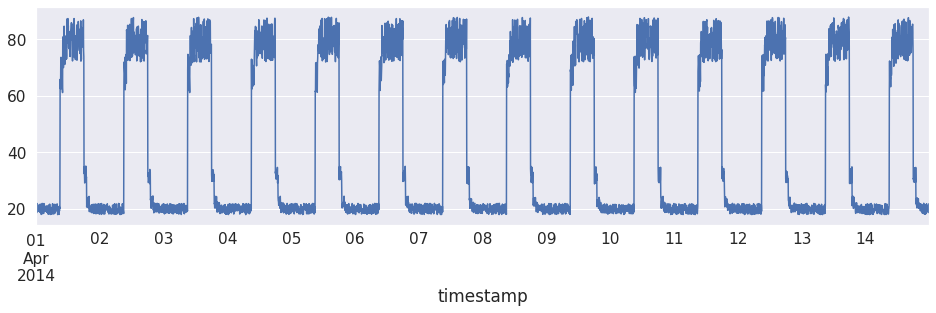

In [9]:
fig, ax = plt.subplots(figsize=(16, 4))
df_small_noise.plot(legend=False, ax=ax)
plt.show()

А так выглядят аномалии (тестовая выборка):

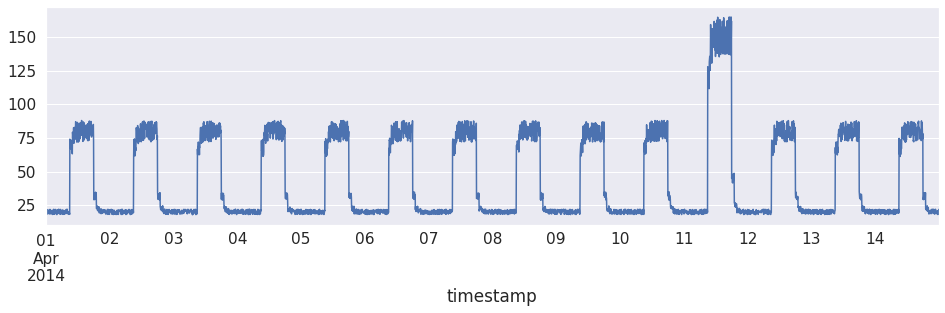

In [15]:
fig, ax = plt.subplots(figsize=(16, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show();

## Обработка данных

Нормализуем значения признака
`value`. У нас есть `value` для 14 дней с периодичностью 5 минут

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [16]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

Сгенерируем последовательности длительностью в один день (288 timesteps), а также разделим выборку на train и val:

In [22]:
TIME_STEPS = 288

def create_sequences(values, time_steps=TIME_STEPS):
  output = []
  for i in range(len(values) - time_steps):
    output.append(values[i : i + time_steps])
  return torch.FloatTensor(np.array(output)).permute(0, 2, 1)


In [23]:
X = create_sequences(df_training_value.values)
X_train, X_val = train_test_split(X, train_size=0.1, shuffle=False)
print("Training input shape: ", X_train.shape)
print("Valid input shape: ", X_val.shape)

Training input shape:  torch.Size([374, 1, 288])
Valid input shape:  torch.Size([3370, 1, 288])


In [27]:
train_loader = DataLoader(X_train, batch_size=4, shuffle=False)
valid_loader = DataLoader(X_val, batch_size=4, shuffle=False)

## Построение модели

Мы будем строить сверточный автоэнкодер, принимающий на вход тензор размерности `(batch_size, sequence_length, num_features)` и возвращающий тензор такой же размерности. В нашем случае `sequence_length = 288` и
`num_features = 1`.

In [38]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv1d(in_channels=32, out_channels=16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=7, stride=1, padding=3),
        nn.ReLU(),
        nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=7, stride=1, padding=3),
    )

  def forward(self, sample):
    latent = self.encoder(sample)
    reconstructed = self.decoder(latent)
    return reconstructed

## Обучение

Заметим, что поскольку мы занимаемся реконструкцией, train/val у нас выступает как в роли входа для сети, так и в роли таргета

In [47]:
epochs = 12
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Training device: ", device)

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

summary(model=model, input_size=(1, 288))


Training device:  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 288]             256
              ReLU-2              [-1, 32, 288]               0
            Conv1d-3              [-1, 16, 288]           3,600
              ReLU-4              [-1, 16, 288]               0
   ConvTranspose1d-5              [-1, 16, 288]           1,808
              ReLU-6              [-1, 16, 288]               0
           Dropout-7              [-1, 16, 288]               0
   ConvTranspose1d-8              [-1, 32, 288]           3,616
              ReLU-9              [-1, 32, 288]               0
  ConvTranspose1d-10               [-1, 1, 288]             225
Total params: 9,505
Trainable params: 9,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB

In [48]:
train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs)):
  model.train()
  train_losses_epoch = []
  for X_batch in train_loader:
    optimizer.zero_grad()
    reconstructed = model(X_batch.to(device))
    loss = criterion(X_batch.to(device), reconstructed)
    train_losses_epoch.append(loss.item())
    loss.backward()
    optimizer.step()
  train_losses.append(np.array(train_losses_epoch).mean())

  model.eval()
  valid_losses_epoch = []
  with torch.no_grad():
    for X_batch in valid_loader:
      reconstructed = model(X_batch.to(device))
      loss = criterion(reconstructed, X_batch.to(device))
      valid_losses_epoch.append(loss.item())
    valid_losses.append(np.array(valid_losses_epoch).mean())
    

  0%|          | 0/12 [00:00<?, ?it/s]

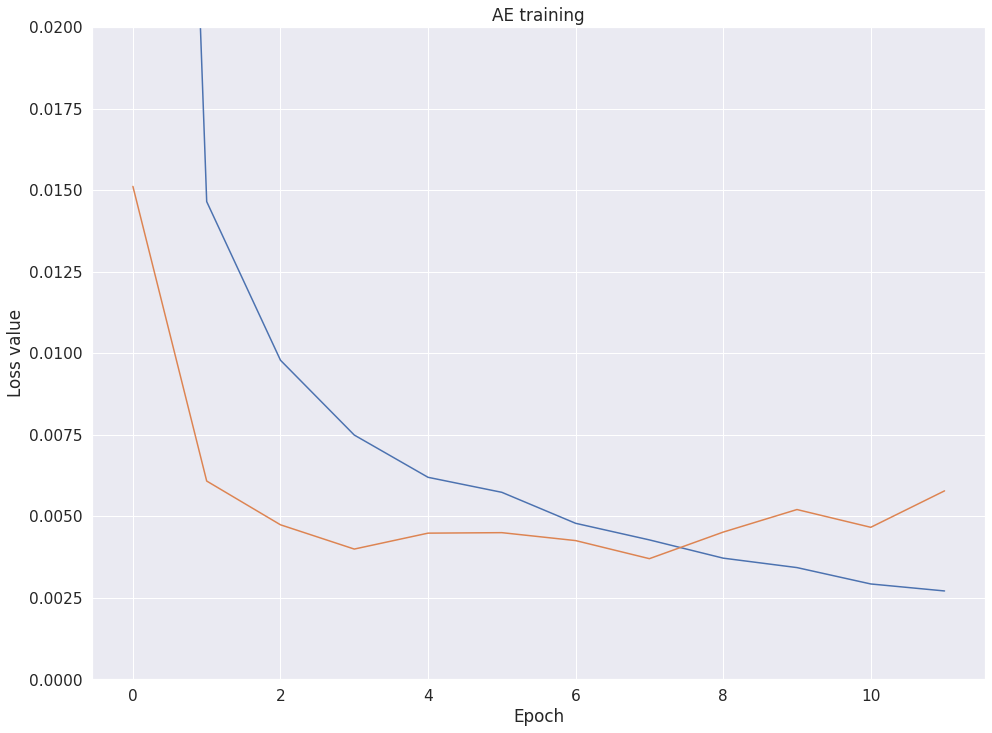

In [49]:
plt.figure(figsize=(16, 12))

plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")

plt.ylim(0, 0.02)
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.title("AE training")
plt.show()

## Детекция аномалий

Как мы уже говорили раньше, мы будем детектировать аномалии на основании того, насколько хорошо сеть воссоздает исходную последовательность. Более подробно


1.   Посчитаем MAE на трейне.
2.   Найдем максимум MAE на трейне. Это будет нашим порогом (`threshold`) для детекции (мы считаем, что на трейне аномалий нет)
3.   Если лосс больше `threshold`, то скорее всего у нас встретился паттерн, который автоэнкодер не видел при обучении. Будем считать его аномалией


In [50]:
X_loader = DataLoader(X, batch_size=1)

model.eval()
threshold = 0.0
x_pred = []

with torch.no_grad():
  for X in X_loader:
    pred = model(X.to(device)).cpu().numpy()
    x_pred.append(pred.ravel())
    mae_loss = np.mean(np.abs(pred - X.numpy()))

    if mae_loss > threshold:
      threshold = mae_loss

print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.06149481


Давайте посмотрим, насколько хорошо наша модель воспроизводит даныые с первого дня:

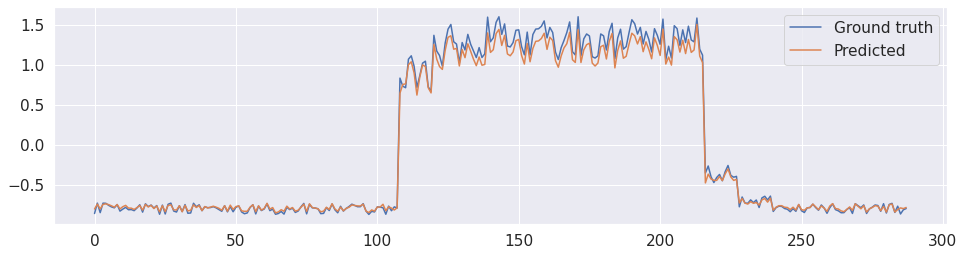

In [52]:
plt.figure(figsize=(16, 4))
plt.plot(X_train[0].numpy().ravel(), label="Ground truth")
plt.plot(x_pred[0], label="Predicted")

plt.legend()
plt.show()

## Детекция на тестовых данных

Проделаем все, о чем мы говорили раньше:

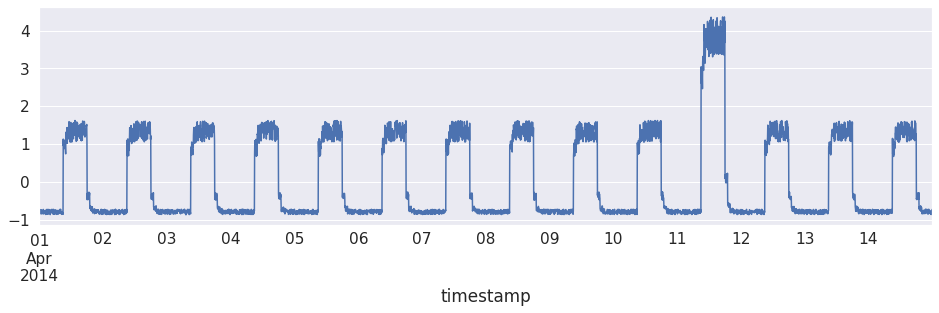

In [53]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots(figsize=(16, 4))
df_test_value.plot(legend=False, ax=ax)
plt.show();

In [54]:
X_test = create_sequences(df_test_value.values)
test_loader = DataLoader(X_test, batch_size=1, shuffle=False)
print("Test input shape: ", X_test.shape)

Test input shape:  torch.Size([3744, 1, 288])


In [55]:
test_losses = []

model.eval()
with torch.no_grad():
  for X in test_loader:
    pred = model(X.to(device)).cpu().numpy()
    mae_loss = np.mean(np.abs(pred - X.numpy()))
    test_losses.append(mae_loss)


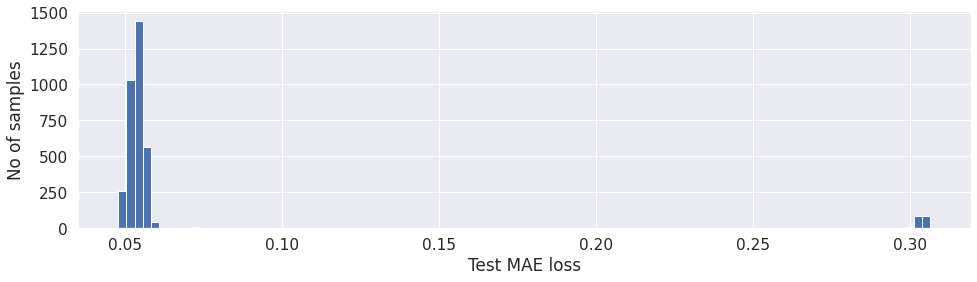

In [60]:
plt.figure(figsize=(16, 4))
plt.hist(test_losses, bins=100)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [61]:
anomalies = test_losses > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  396
Indices of anomaly samples:  (array([2519, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
       2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2

Как мы видим, некоторые индексы помечены как аномальные. Давайте теперь определим границы аномалий и изобразим их на графике

## Графики аномалий

Теперь мы хотим найти аномальные `timestamps` из теста. Будем делать так:

Пусть к примеру `time_steps = 3` и в нашей выборке 10 значений. Наш `x_train` будет выглядеть так:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

Все значения, кроме начального и последних `time_steps - 1`, появятся в данных
`time_steps` number of samples.  Поэтому, если мы знаем, что последовательности
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] – это аномалии, мы можем сказать, что аномалия произошла в момент времени 5

In [63]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
  if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
    anomalous_data_indices.append(data_idx)

Изобразим на графике тестовые данные

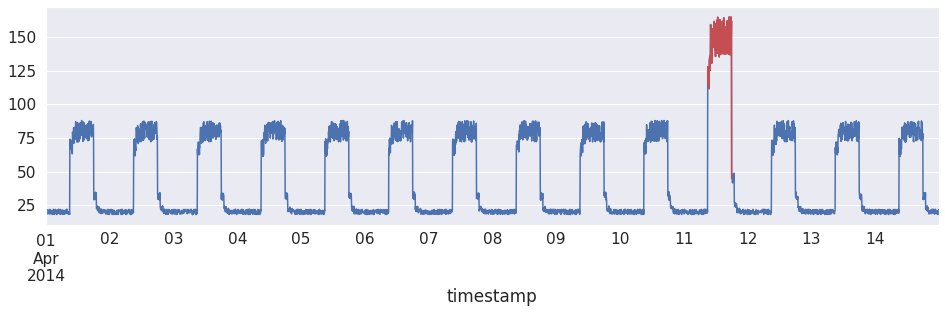

In [66]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(16, 4))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()